In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import math
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


In [2]:
# Mutual information scores
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [3]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(df[name].median())
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [4]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
        
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


In [5]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [6]:
# Get data
kaituna_data = pd.read_csv('../input/kaitunadata/kaituna_data_2020-01-01_2022-10-18.csv',parse_dates=["TimeStamp"])
kaituna_data["TimeStamp"] = pd.to_datetime(kaituna_data['TimeStamp'])

In [7]:
# Feature creation

#Average gate level
kaituna_data["AverageGate"] = kaituna_data[["Gate1", "Gate2", "Gate3"]].mean(axis=1)
rounding_level = 100
kaituna_data["AverageGateOrdinal"] = rounding_level * round(kaituna_data["AverageGate"] / rounding_level)

# Extract hour, day, month, year from TimeStamp
kaituna_data["Hour"] = kaituna_data["TimeStamp"].dt.hour
kaituna_data["DayOfWeek"] = kaituna_data["TimeStamp"].dt.day_of_week
kaituna_data["Month"] = kaituna_data["TimeStamp"].dt.month
kaituna_data["Year"] = kaituna_data["TimeStamp"].dt.year

<AxesSubplot:xlabel='TimeStamp', ylabel='LakeLevel'>

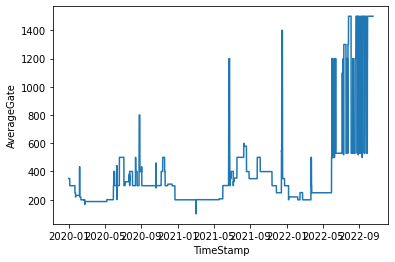

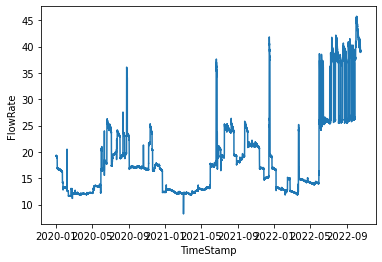

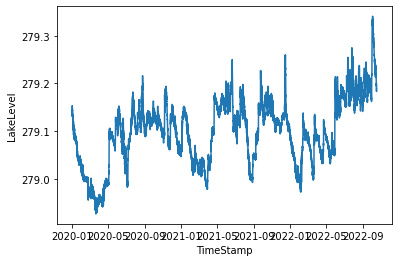

In [8]:
# Exploration of the target variables
sns.lineplot(x=kaituna_data["TimeStamp"],y=kaituna_data["AverageGate"])
plt.figure()
sns.lineplot(x=kaituna_data["TimeStamp"],y=kaituna_data["FlowRate"])
plt.figure()
sns.lineplot(x=kaituna_data["TimeStamp"],y=kaituna_data["LakeLevel"])

In [9]:
#Define categorical columns
categorical_cols = ['Hour', 'DayOfWeek', 'Month', 'Year', 'AverageGateOrdinal']
levels = []
for col in categorical_cols:
    kaituna_data[col] = kaituna_data[col].astype('category')

#Numerical columns
numerical_cols = ['FlowRate','AverageGate','Rainfall','LakeLevel']

In [10]:
# Shape
print(kaituna_data.shape)

# Describe
print(kaituna_data.describe())

# Describe ordinal variables
print(kaituna_data[categorical_cols].describe())

(24363, 13)
          LakeLevel      FlowRate         Gate1         Gate2         Gate3  \
count  24362.000000  24363.000000  24363.000000  24363.000000  24363.000000   
mean     279.098471     18.640451    380.565858    383.562082    396.321061   
std        0.068997      7.455764    339.967036    324.366752    327.218331   
min      278.926000      8.222558      0.000000      0.000000      0.000000   
25%      279.050000     12.881968    200.000000    210.000000    220.000000   
50%      279.105000     16.851547    299.000000    299.000000    299.000000   
75%      279.144000     21.414067    449.000000    399.000000    400.000000   
max      279.341000     45.757437   1500.000000   1500.000000   1500.000000   

           Rainfall   AverageGate  
count  24363.000000  24363.000000  
mean       0.168105    386.816334  
std        0.860482    313.279508  
min        0.000000     99.000000  
25%        0.000000    200.000000  
50%        0.000000    299.000000  
75%        0.000000    3

In [11]:
# Get features and target
feature_columns = ["LakeLevel","Rainfall", 'Hour', 'DayOfWeek','Month']

y = kaituna_data[["FlowRate"]]
X = kaituna_data[feature_columns]

# Feature creation
X_previous_flows = make_lags(y, lags=4)

# Concatenate
X = pd.concat([X, X_previous_flows],axis=1)

#Shift data so that we have only values that exist
y, X = y.align(X, join='inner', axis=0)

#Categorical features
categorical_features = ['Hour', 'DayOfWeek', 'Month']

#Numerical features
numerical_features = ['Rainfall','LakeLevel']

print(X.head())


   LakeLevel  Rainfall Hour DayOfWeek Month  (y_lag_1, FlowRate)  \
0    279.152       0.0    0         2     1                  NaN   
1    279.150       0.0    1         2     1            19.288053   
2    279.152       0.0    2         2     1            19.159514   
3    279.153       0.0    3         2     1            19.185197   
4    279.153       0.0    4         2     1            19.210892   

   (y_lag_2, FlowRate)  (y_lag_3, FlowRate)  (y_lag_4, FlowRate)  
0                  NaN                  NaN                  NaN  
1                  NaN                  NaN                  NaN  
2            19.288053                  NaN                  NaN  
3            19.159514            19.288053                  NaN  
4            19.185197            19.159514            19.288053  


In [12]:
#Test train split
# Divide data into training and validation subsets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, test_size=0.4)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.5, test_size=0.5)

In [13]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Regressor model
model = XGBRegressor(n_estimators = 100, random_state=-1)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


MAE: 1.36171303046105


<AxesSubplot:xlabel='FlowRate', ylabel='FlowRate'>

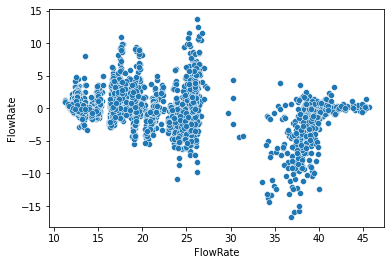

In [14]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

# Plot
sns.scatterplot(x=y_valid["FlowRate"], y=preds-y_valid["FlowRate"])

In [15]:
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
final_score = scores.mean()
print(final_score)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packag

3.606384553689497


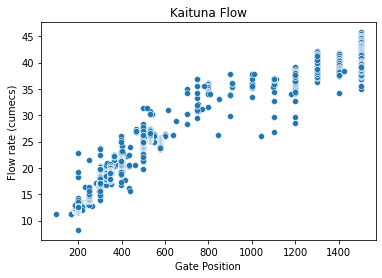

In [16]:
# Visualise gate levels
palette = ['tab:blue', 'tab:green', 'tab:red']
gates_to_cumecs = sns.scatterplot(
    x=kaituna_data["AverageGate"], 
    y=kaituna_data["FlowRate"], 
    #hue=kaituna_data["Year"],
    #palette='Set1'
    )
plt.ylabel('Flow rate (cumecs)')
plt.xlabel("Gate Position")
plt.title("Kaituna Flow")
plt.show()

#plt.savefig("gates_to_cumecs.png")